# Central Carbon Cycling in SAGs

While the genomes are incomplete and it is expected that central carbon metabolism genes might be missed in the SAGs, we will hopefully regenerate a facsimile of Table S9 here. 

In [230]:
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as cls

## Loading Files

From here, we're dealing with the output from eggNOG, a metabolic gene mapper. 
This program puts out files that are a bit messy, but I cut them with `../scripts/split_proteins.sh`.

Now, the files in `../../../data/eggNOGged/*/` each contain what is effectively a tab-separated value file with a lot of holes called `*_cut.txt`. This shows the output of eggNOG in the following format for the best hits on each SAG:
*query_name	seed_eggNOG_ortholog	seed_ortholog_evalue	seed_ortholog_score	best_tax_level	Preferred_name	GOs	__EC__	KEGG_ko	KEGG_Pathway	KEGG_Module	KEGG_Reaction	KEGG_rclass	BRITE	KEGG_TC	CAZy	BiGG_Reaction	taxonomic scope	eggNOG OGs	best eggNOG OG	COG Functional cat. eggNOG free text desc.*

That *EC* is what we're really concerned with---it's what the authors use to outline the central carbon metabolism, and is one of several ways to denote a metabolic reaction. The actual SAG names have been matched with taxonomic (often phylum) groupings by the original authors. We'll need that match, so I created a short document called `../wrangling/taxon_match.tsv` that has the pairings written in manually. As a bonus, it includes the sampling locations.

I have effectively reproduced fig. S9 in the file `../wrangling/enzyme_nos.csv`. This will be used both for comparison and for pairing enzymes with their *EC*.

In [231]:
taxon_match=pd.read_csv('../wrangling/taxon_match.tsv', delimiter='\t') # The matched SAG/taxon IDs
cut_files=glob.glob('../../data/eggNOGged/*/*_cut.txt') # List of all eggNOG outputs.
TS9=pd.read_csv('../wrangling/enzyme_nos.csv', delimiter='\t') # The reproduced Table S9. 1 where the genes were found, 0 otherwise.

## Restriction
Not in the sense that we're processing DNA, but in the sense that Table S9  is restricted to three clades of *gammaproteobacteria*: __SAR86__, __ARCTIC__, and __SAR92__.

In [232]:
SAR86=taxon_match.groupby('TAXON').get_group('SAR86')
ARCTIC=taxon_match.groupby('TAXON').get_group('Arctic96BD-19')
SAR92=taxon_match.groupby('TAXON').get_group('SAR92')

ID_SAR86=list(SAR86['SAG_ID'])
ID_ARCTIC=list(ARCTIC['SAG_ID'])
ID_SAR92=list(SAR92['SAG_ID'])

ID_G=ID_SAR86 + ID_ARCTIC + ID_SAR92 # The SAG IDs for all Gammaproteobacteria.

# Here I strip down the filenames from all SAGs to match them with SAG IDs that represent gammaproteobacteria.
G_files = []
for item in cut_files:
    if os.path.basename(item)[:-8] in ID_G:
        G_files = G_files + [item]

G_files # These should be the files that we're looking for.

assert(len(G_files)==len(ID_G)), "Looks like there's not the same number of taxa to match the eggNOG files."

## Matching

Well, here we are. We know which files we're looking at based on `G_files`. I'm going to do this carefully, loading and deleting one file at a time, because these files are hundreds of kilobytes.

1. Load each in as a pandas DataFrame object. Retain only the taxonomic information from the file and the *EC*. 
2. Query the *EC* column for the matching enzyme numbers. 
3. Create a vector of 0s and 1s and store it in a master DataFrame not unlike that of Table S9.

__NOTE: We already have one extra member in the analysis, a member of SAR86!__

In [233]:
master=pd.concat([TS9['RXN'],TS9['EC'],TS9['Pathway']], 1) # Creates the empty dataframe with enzyme ID columns.

for file in G_files: # For each gammaproteobacterial SAG.
    SAG=pd.read_csv(file, sep='\t', usecols=['EC']) # Read in the #######_cut.txt, but just the EC column.
    #print(SAG['EC'][3]) # A test
    test=[] # Preallocate the variable for enzyme yes/no matching
    for enzyme in TS9['EC']:
        if enzyme in list(SAG['EC']): # Test to see if the enzyme string matches any of the SAG's enzymes.
            test += [1]
        else:
            test += [0]        
    Presence_Absence=pd.DataFrame(test, columns=[os.path.basename(file)[:-8]]) # Use the taxon name as the column ID
    master=pd.concat([master,Presence_Absence], 1)
master

,RXN,EC,Pathway,AAA076-P13,AAA536-J20,AAA076-F14,AAA076-E13,AAA536-N21,AAA076-D02,AAA298-N10,AAA076-D13,AAA160-D02,AAA300-D14,AAA168-P09,AAA168-I18,AAA076-P09
0,glucokinase,2.7.1.2,Glycolysis,1,0,1,1,0,1,1,1,1,1,1,0,1
1,glucose-6-phosphate isomerase,5.3.1.9,Glycolysis,1,0,0,0,0,0,0,0,1,1,1,1,0
2,aldose 1- epimerase,5.1.3.3,Glycolysis,0,0,1,1,0,1,0,1,0,1,0,0,0
3,6-phosphofructokinase,2.7.1.11,Glycolysis,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"fructose 1,6- bisphosphate aldolase",4.1.2.13,Glycolysis,1,1,1,1,1,1,1,1,0,1,1,1,1
5,triosephosphate isomerase,5.3.1.1,Glycolysis,0,0,1,0,1,1,1,1,1,1,1,1,0
6,glyceraldehyde-3- phosphate dehydrogenase,1.2.1.12,Glycolysis,1,0,1,1,0,1,0,1,1,1,1,0,1
7,phosphoglycerate kinase,2.7.2.3,Glycolysis,0,0,0,0,0,0,0,0,0,0,0,0,0
8,phosphoglycerate mutase,5.4.2.1,Glycolysis,0,0,0,0,0,0,0,0,0,0,0,0,0
9,enolase,4.2.1.11,Glycolysis,1,0,1,1,1,1,1,1,1,1,1,1,1


## Comparison

Great! It looks like our results were, in fact, fundamentally different from those of Swan et al., and now we'll produce a heatmap to show exactly where the results differed. The following results will show those taxa that were mutually evaluated. 

To interpret what I just did, note the line, `compare = master_compare - TS9_compare`. This means...

1. A `compare` value of -1 indicates that Swan et al. detected a gene that eggNOG didn't.
2. A `compare` value of 0 indicates we both detected the same enzyme in the SAG...or that both didn't find it. Either way, they performed the same. 
3. A `compare` value of 1 indicates that eggNOG saw something that Swan et al. missed.

In [237]:
# First we'll break off the metadata so that the underlying presence/absence data can be dealt with in a way that makes 
# sense to my tiny brain. 
master_sorted = master[TS9.columns]
master_sorted.to_csv('../output/TableS9redux.csv')
master_compare = master_sorted[master_sorted.columns[3::]]
TS9_compare = TS9[TS9.columns[3::]]

compare = master_compare - TS9_compare # Yes, this one.

compare = pd.concat([TS9[TS9.columns[0:2]], compare], 1)
compare.pop('EC')
compare.set_index('RXN')

,AAA076-P09,AAA076-P13,AAA168-I18,AAA168-P09,AAA298-N10,AAA076-D02,AAA076-D13,AAA076-E13,AAA076-F14,AAA160-D02,AAA300-D14
RXN,,,,,,,,,,,
glucokinase,1,1,0,1,1,1,0,0,0,0,0
glucose-6-phosphate isomerase,0,0,0,0,0,-1,-1,-1,-1,0,0
aldose 1- epimerase,0,-1,-1,-1,0,0,0,0,0,-1,0
6-phosphofructokinase,-1,-1,-1,-1,-1,-1,0,0,-1,0,0
"fructose 1,6- bisphosphate aldolase",0,0,0,0,0,0,0,0,0,0,1
triosephosphate isomerase,-1,-1,0,0,0,0,0,0,0,0,0
glyceraldehyde-3- phosphate dehydrogenase,0,0,-1,0,-1,0,0,0,0,0,0
phosphoglycerate kinase,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1
phosphoglycerate mutase,0,-1,-1,-1,-1,-1,-1,0,-1,0,-1


## Easy on the eyes.

Now, I'll offer up a couple things to summarize all of this:

1. A heatmap to visually show you how well this went.
2. Some numbers.

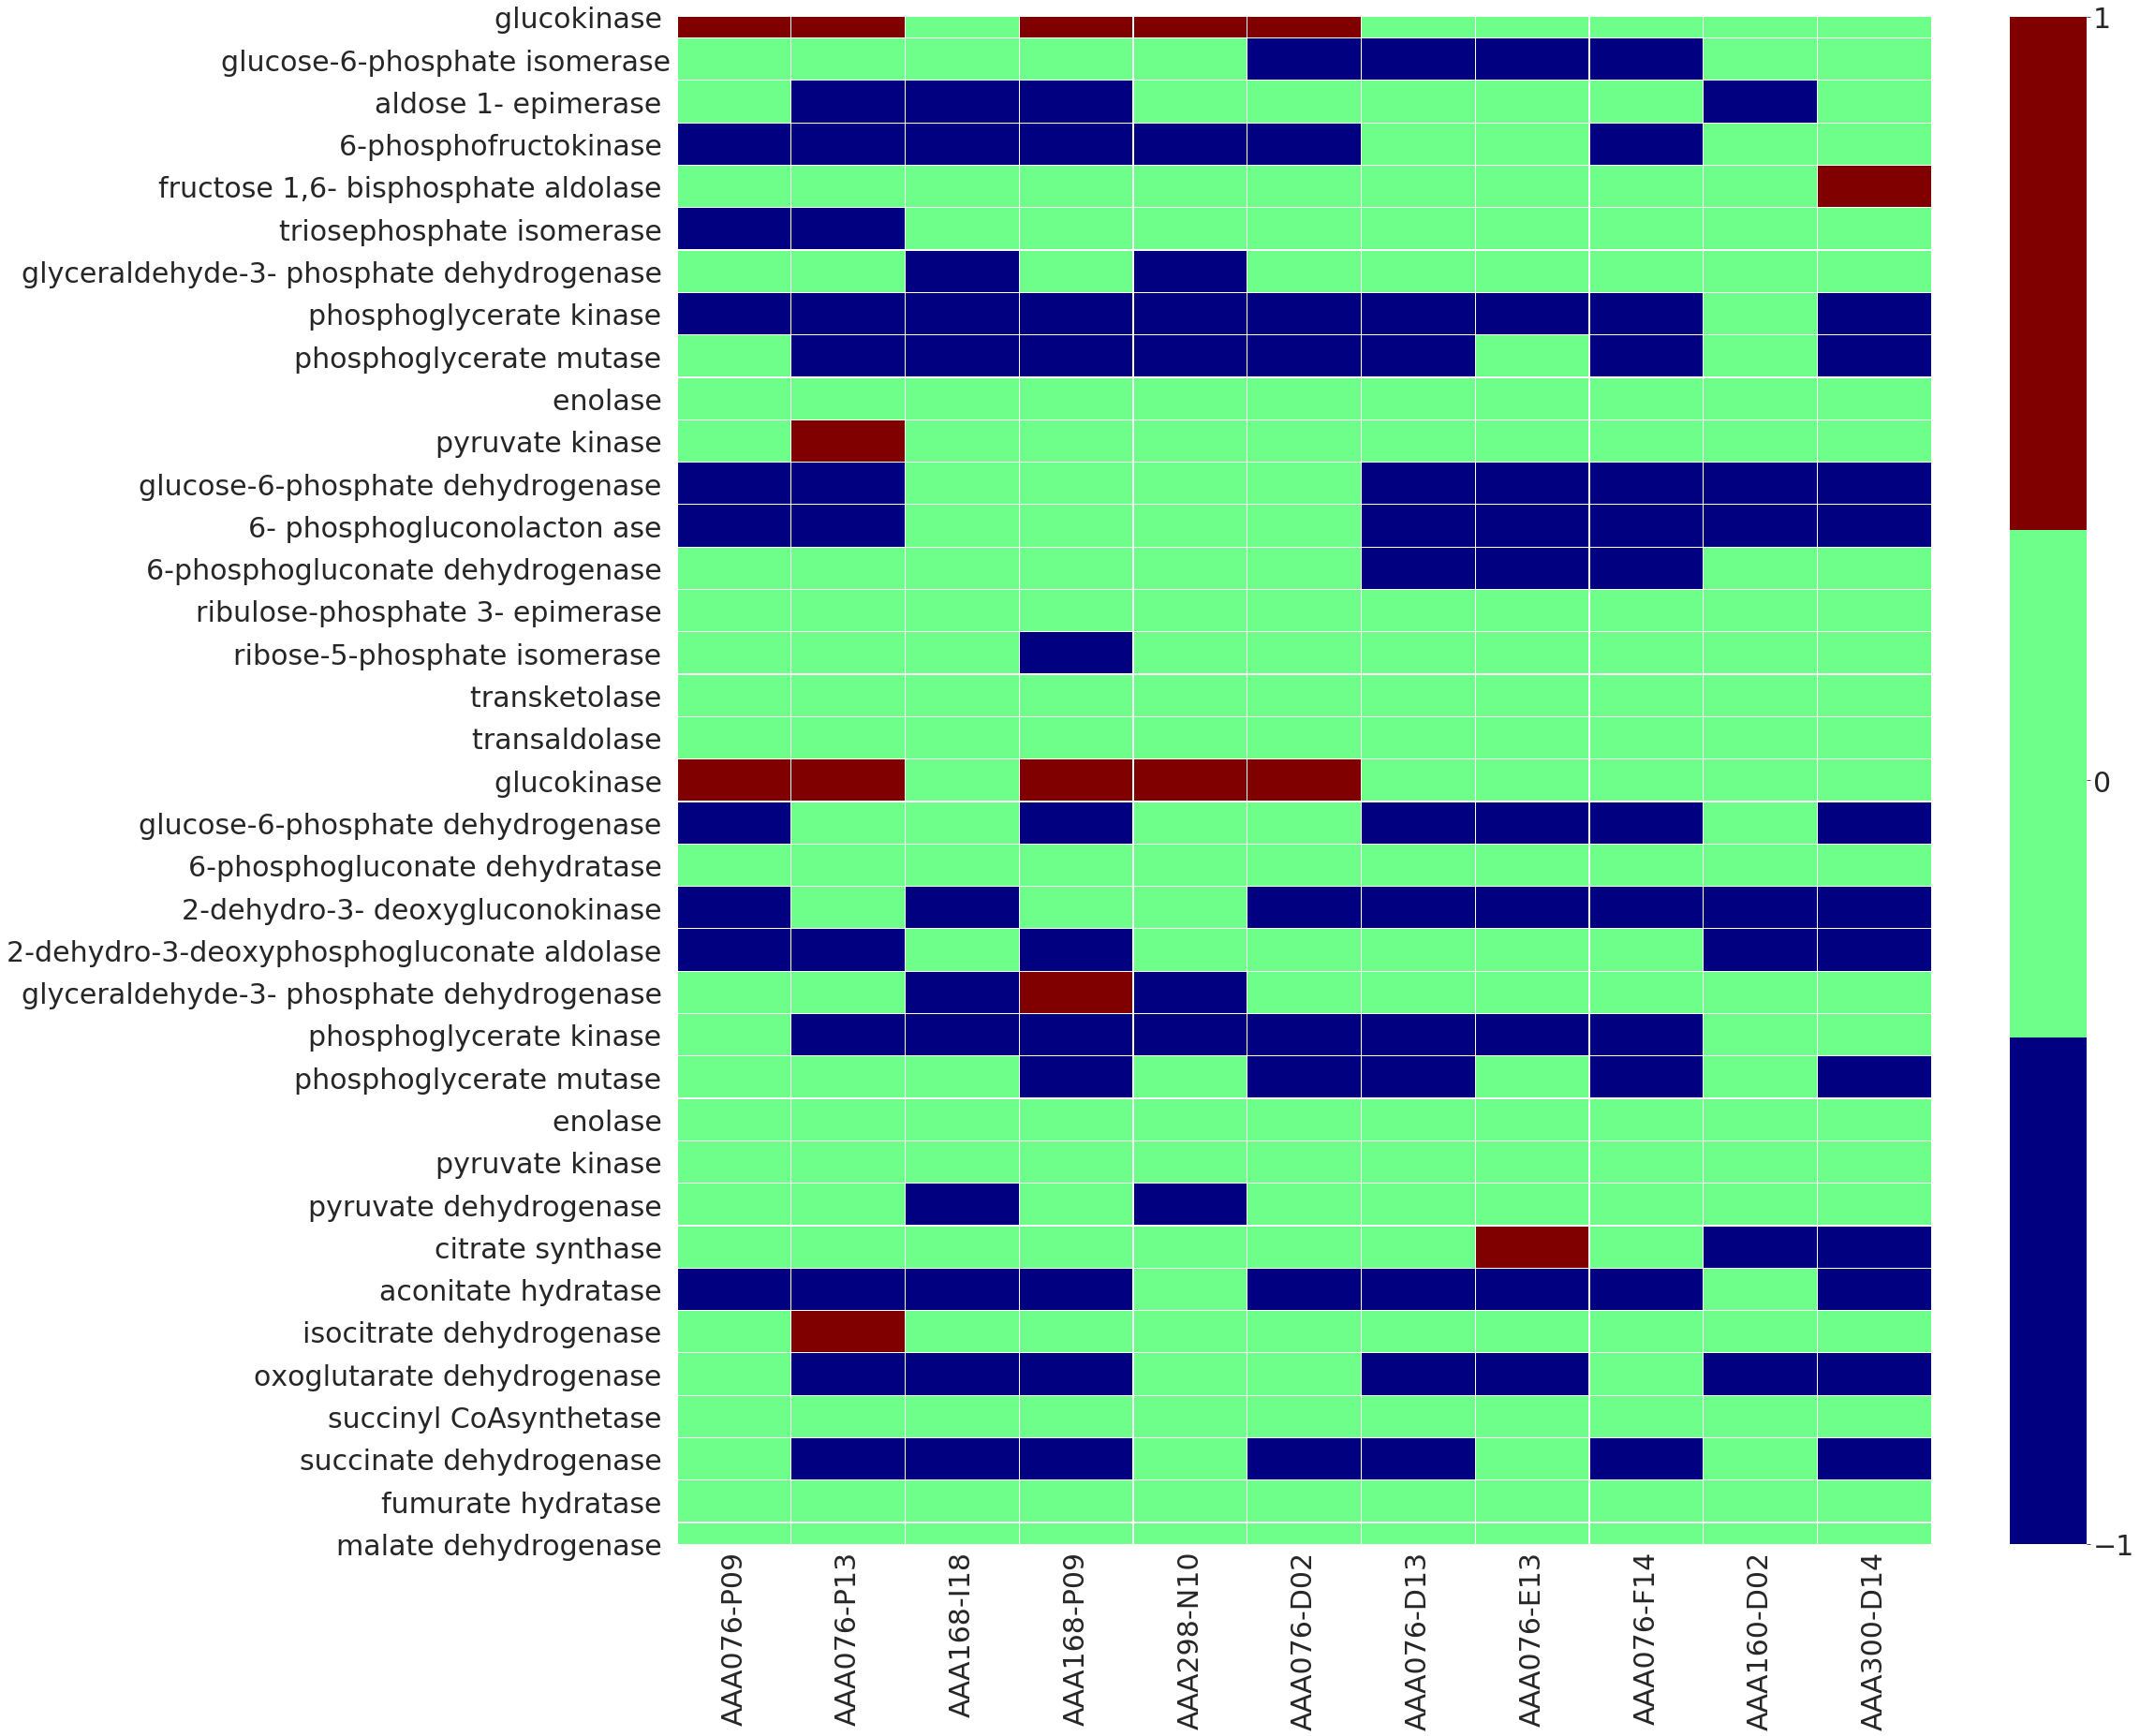

In [235]:
fig, ax = plt.subplots(figsize=(30, 30))
sns.set_style("dark")
colormap=[plt.cm.jet(i) for i in [0,123,256]]
plot = sns.heatmap(compare[compare.columns[1:]].apply(pd.to_numeric),
                   linewidths=0.25, vmin=-1, vmax=1, center=0, cmap=colormap,#cbar=False,
                   yticklabels=compare['RXN'], cbar_kws=dict(ticks=[-1, 0, 1]))
plt.rcParams.update({'font.size': 30})
plt.rc({'weight': 'bold'})
ax.set_facecolor("white")
plt.savefig('../output/plots/Metabolism_Compare.png')

In [236]:
Hits_eggNOG = np.count_nonzero(master_sorted[master_sorted.columns[3:]])
Hits_eggNOG_percent = 100*Hits_eggNOG/master_sorted[master_sorted.columns[3:]].size
Hits_eggNOG_percent

Hits_2013 = np.count_nonzero(TS9[TS9.columns[3:]])
Hits_2013_percent = 100*Hits_2013/TS9[TS9.columns[3:]].size
Hits_2013_percent

print('For the taxa that both projects analyzed, Swan et al. had hits on {hits}% of central carbon enzymes.'.format(hits=Hits_2013_percent))
print('EggNOG had hits on {hits}% of central carbon enzymes.'.format(hits=Hits_eggNOG_percent))

For the taxa that both projects analyzed, Swan et al. had hits on 71.74447174447174% of central carbon enzymes.
EggNOG had hits on 46.92874692874693% of central carbon enzymes.


# Conclusions

In case you didn't catch it, the 2013 approach of "use a bunch of different databases and synthesize the results" was not actually quite paralleled by the use of eggNOG. What we got running this notebook:

__Swan et al: Avg 71.7 % completeness for the Central Carbon Metabolism.__

__Berger, Tobias, and Germolus: 46.9 % completeness for the same enzymes.__